[View in Colaboratory](https://colab.research.google.com/github/chanthony/IndiaAgriculture/blob/master/Agriculture.ipynb)

# Introduction

Computer science and data science in particular has spread into many fields and aspects of life. One of the aspects which has not had much exposure to data science is agriculture. In this project we attempted to apply data science to better understand agriculture and in particular the production of cereals. 

Cereals are what consumers usually think of as grains such as wheat, rice, or even corn. This family of crops makes up a significant portion of food consumption around the world as well as having applications such as ethanol production. Their prevalence in our daily lives is part of what makes study about their production so interesting.

In this project we attempted to build a predictive model to take in various aspects of a countries agricultural industry and predict cereal production for that country. By studying these models we can start to make some observations regarding how these aspects relate to agriculture

# Data Set

For this project we used data  from the World Bank as part of their World Development Indicators data set. You can explore that dataset on your own [here](http://databank.worldbank.org/data/reports.aspx?source=world-development-indicators). The data set has over 1500 different features for 241 countries stretching as far back as 1960. These features describe the countries in many aspects ranging from the economy to environmental characteristics. For this data set we selected a subset of variables to consider that pertained to agriculture.

Each row in the dataframe is the value for a given indicator for a specific country and year combination. The columns are the country code, the year, and the indicator code as well as the value for the given indicator. Since we are predicting for each country we will need to transform the data set so country year combinations are combined into a single row rather than split across multiple rows.

# Libraries

This project relies upon the support of a few libraries to make everything work.

The data file we used is stored in a csv. To get that file we use `requests` and we use `io` to process it

In [0]:
import requests
import io

To help manage all of our data we use pandas dataframes.

In [0]:
import pandas as pd

For dealing with the the mathematical portion of our calculations as well as matrix calculations we use numpy

In [0]:
import numpy as np

For our models we use an sklearn backend. Each model is imported seperately for clarity.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

from sklearn import feature_selection

from sklearn.linear_model import LinearRegression as sklr

#Support Vector Regression
from sklearn.svm import SVR

#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
#Parameter tuning for RFR
from sklearn.model_selection import RandomizedSearchCV

And finally for data visualization we used matplotlib and seaborn for some specialized graphs.

In [0]:
# Data Vis
import matplotlib.pyplot as plt
import seaborn as sns

#Used to remove warnings for some deprecat4ed functions
import warnings 
warnings.filterwarnings('ignore')

#Set style for plots
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')

# Reading and Formatting the Data Frame

To start we read in the data from a csv file called `indicators.csv`

In [9]:
#Read in data frame
indicators = pd.read_csv('indicators.csv', sep = ',')
indicators.head(9)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06
5,Arab World,ARB,Arms imports (SIPRI trend indicator values),MS.MIL.MPRT.KD,1960,5.380000e+08
6,Arab World,ARB,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,1960,4.769789e+01
7,Arab World,ARB,CO2 emissions (kt),EN.ATM.CO2E.KT,1960,5.956399e+04
8,Arab World,ARB,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,1960,6.439635e-01


## Extract the relevant rows

Now that we have the dataframe we select the indicators. We preselected a set of indicators relevant to agriculture. We begin by putting our selected variables into a dictionary with the key being the human readable name for the indicator and the value being the indicator code used by the dataset.

In [0]:
#Select only relevant indicators
ag_indicators = {
    'ag machinery, tractors':'AG.AGR.TRAC.NO',
    'ag machinery per 100 sq km':'AG.LND.TRAC.ZS',
    'ag value added per worker':'EA.PRD.AGRI.KD',
    'cereal production, tons':'AG.PRD.CREL.MT',
    'cereal yield, kg per hectare':'AG.YLD.CREL.KG',
    'fertilizer consumption, % (quantity used per unit of arable land)':'AG.CON.FERT.PT.ZS',
    'fertilizer consumption, kg per hectare of arable land':'AG.CON.FERT.ZS',
    'land under cereal production, hectare':'AG.LND.CREL.HA',
    'ag irrigated land, %':'AG.LND.IRIG.AG.ZS',
    'ag total land, %':'AG.LND.AGRI.ZS',
    'ag total land, sq km':'AG.LND.AGRI.K2',
    'arable land, %':'AG.LND.ARBL.ZS',
    'arable land, hectares':'AG.LND.ARBL.HA',
    'average precipitation, mm per year':'AG.LND.PRCP.MM',
    'land area, sq km':'AG.LND.TOTL.K2',
    'permanent cropland, %':'AG.LND.CROP.ZS',
    'food production index':'AG.PRD.FOOD.XD',
    'value added agriculture':'NV.AGR.TOTL.KD'
}    


Now that we have defined what indicators we want to select we run through our data and select only the rows which have indicator codes matching the ones in our dictionary. We then store these in a dictionary where the key is the indicator code and the value is all the relevant rows.

In [0]:

#Formatted as a dict keyed by indicator code
#Each value is a dataframe containing the rows relevant to the indicator split by country and year
agDF = {}
keys = []
values = []
for key, value in ag_indicators.items():
    rows = indicators.loc[indicators['IndicatorCode'] == value][['CountryCode', 'Year', 'Value']]
    keys.append(key)
    values.append(rows)
    agDF[key] = rows 

In addition to the features built into the table, we define an additional feature corresponding to the raw fertilizer consumption by country.

In [0]:

#Calculate total fertilizer used
fertilizer = clean(['fertilizer_consumption', 'arable_land'],
                    agDF['fertilizer consumption, kg per hectare of arable land'],
                    agDF['arable land, hectares'])
fertilizer['Value'] = fertilizer.fertilizer_consumption * fertilizer.arable_land
fertilizer.drop(['fertilizer_consumption','arable_land'],axis=1,inplace=True)

agDF['fertilizer'] = fertilizer
keys.append('fertilizer')
values.append(fertilizer)

##Format the indicators into one data frame

This part is actually jumpting ahead a little bit but it's easier to solve now than later. The countries in the data set aren't strictly countries. Some of the "countries" are actually regions. The problem that arises is that countries end up getting double counted which in some cases can skew our results. As such when we collect our data set we preemptively remove the non-country countries. 

In [0]:
regions = ['ARB','CSS','EAS','EAP','ECS','ECA','EUU','FCS','HPC','HIC','NOC','OEC','LCN',
           'LAC','LDC','LMY','LIC','LMC','MEA','MNA','MIC','NAC','MNP','OED','OSS','PSS',
           'SST','SAS','ZAF','SSF','SSA','UMC','WLD']


We define a helper

function we refer to as `clean`. This function takes in the column names and a series of data frames corresponding to the different indicators. These frames are merged together by the country code and year. By the time this is done we should have a data frame where each row is a country/year pair and the columns are the features we selected.

In [0]:
"""
clean: Formats the frames given in df1 and *data to make a single data frame
input: list of string + dataframe
names: column names for given columns in order
output: dataframe in format: CountryCode, year, indicators**
"""
def clean(names, df1, *data):
    n = 0
    df = df1.copy()
    if 'Value' in df1.columns.values:
        df.rename(columns={'Value':names[n]}, inplace=True)
        n += 1
    for f in data:
        frame = f.copy()
        if 'Value' in frame.columns.values:
            frame.rename(columns={'Value':names[n]}, inplace=True)
            n += 1
        df = pd.merge(df, frame, how='left', on=['CountryCode','Year'])
    # Necessary to remove the double-counting regions noted in the first section
    for name in regions:
        df.drop(df.loc[df.CountryCode == name].index, inplace=True)
    return df


We drop the country code and year for two reasons. The first reason is that we simply no longer need them. None of our models are cluster based or otherwise rely on knowing the labels. The second reasons is that non-numeric features get in the way of any mathematical calculations done on the data frames so it is simply easier to just remove them.

In [15]:

df = clean(
    ["cereal production", 'tractors', 'fertilizer', 'average precipitation', 'land under cereal production',
     'ag total land', 'arable land', 'land area'],
    agDF['cereal production, tons'],
    agDF['ag machinery, tractors'],
    agDF['fertilizer'],
    agDF['average precipitation, mm per year'],
    agDF['land under cereal production, hectare'],
    agDF['ag total land, sq km'],
    agDF['arable land, hectares'],
    agDF['land area, sq km']
)

keys = []
values = []

for key, val in agDF.items():
  keys.append(key)
  values.append(val)

df = df.drop(['CountryCode','Year'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8686 entries, 2 to 10381
Data columns (total 8 columns):
cereal production               8686 non-null float64
tractors                        5574 non-null float64
fertilizer                      1787 non-null float64
average precipitation           1744 non-null float64
land under cereal production    8686 non-null float64
ag total land                   8672 non-null float64
arable land                     8566 non-null float64
land area                       8686 non-null float64
dtypes: float64(8)
memory usage: 610.7 KB


## Imputation

As can be seen in the data summaries from the previous sections, some of the indicators are rather sparse. In particular, average participation and fertilizer usage both have around 1750 non null rows. To help correct that, we use regression imputation to help fill in some of these non null values.

Essentially, we train a regression model on the rows for which the given indicator is defined and then use that model to predict the values for the rows where the indicator is not defined.

In [0]:
def contains_nan(row):
  return pd.isnull(row).any()

#Imputate: dataframe, string -> dataframe
# Input: Target Dataframe to be imputated, name of column to be imputated
def imputate(df, label):
  #Train the regression model on rows where target column is non null
  train = df.loc[pd.isnull(df[label]) == False]
  
  cols = list(train.columns.values)
  cols.remove(label)
  
  # Further trim our training set by removing any rows where input columns are 
  # null
  train = train.dropna(axis = 0, how = 'any', subset = cols)
  
  #Seperate input output with target label as otuput
  train_y = train[label]
  train_x = train.drop(label, axis = 1)
  
  #Initialize and train model
  regr = sklr()
  
  model = regr.fit(train_x, y = train_y)
  
  #Takes in a row. If target label is not null, simply return the row as is
  #If the target label is null and the rest of the row is non-null, make a prediction
  def f(x):
    x_param = x[:]
    x_param = x_param.drop(label)
    
    if(pd.isnull(x[label]) and not contains_nan(x_param)):
      #Fill in the value using predictions
      return model.predict(x_param.values.reshape(1,-1))
    else:
      return x[label]
  
  #Apply it to every row
  df[label] = df.apply(f, axis = 1)

  return df
  


Since imputation only works for rows where every indicator except the one being targeted is non-null, this greatly restricts the number of rows we can fill in at a time. The main problem is that `fertilizer` and `average precipitation` are both very sparse and have little overlap. In fact, the number of rows in the initial data set where both are non-null is only 88. To fix that, we alternate between imputating over the two indicators over and over again to slowly fill in the data set.  This allows us to get to around 2000 non-null objects at the lowest.

This is still not ideal as in a perfect world we would fill the entire data frame. As regression is not equipped to handle null values spread throughout the dataframe, our imputation model cannot really improve beyond this point. To improve this, different, more robust imputation models may work. A simple solution would be to use mean-value imputation although the accuracy is not quite as guaranteed.

Despite all of its flaws howver, regression imputation does help ensure that the same basic relationships between the indicators are maintained throughout the data set. For models like linear regression which deal with the indicators as a set on a per sample basis, this guarantee is pretty much required.

In [18]:

#Upping this count to 40 creates no significant improvement
for i in range(10):
  df = imputate(df, 'average precipitation')
  df = imputate(df, 'fertilizer')

df = imputate(df, 'tractors')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8686 entries, 2 to 10381
Data columns (total 8 columns):
cereal production               8686 non-null float64
tractors                        5922 non-null object
fertilizer                      2819 non-null object
average precipitation           1958 non-null object
land under cereal production    8686 non-null float64
ag total land                   8672 non-null float64
arable land                     8566 non-null float64
land area                       8686 non-null float64
dtypes: float64(5), object(3)
memory usage: 610.7+ KB


### Data Filtering

For the sake of our regression models, we remove any rows which have a null element at any column. The resulting data frame contains only rows which are filled in every column, whether that be how it came originally or a product of our imputation.

In [19]:
df = df.dropna(axis = 0, how = 'any')

df.shape

(1682, 8)

## Feature Selection

A common problem to have when training a model is having too many variables. As a result of having too many variables, models can often end up overfitting the data leading to a model which doesn't generalize very well. 

Currently our data frame consists of 7 variables which were selected by hand. To see if we can improve any better, we apply feature selection to the selected variables to see if a subset of our selected variables will perform comparitively as well.

### Using SelectKBest

The first feature selection method we employ is SelectKBest from sklearn. This model takes in a scoring system and the set of variables and returns the k variables which score highest. In the default case(which is what we use here), it uses the F-statistic value.

In [20]:
fs = feature_selection.SelectKBest(k = 4)

df_y = df['cereal production']
df_x = df.drop('cereal production', axis = 1)

fs.fit(df_x, df_y)
selected = np.array(df_x.columns.values)[np.array(fs.get_support())]
print(selected)

['tractors' 'land under cereal production' 'arable land' 'land area']


With k = 4, SelectKBest selects `tractors`, `land under cereal production`, `arable land`, and `land area` as the k features which are most likely to produce good results.

### Using Recursive Feature Elimination

The second method we use which is a little more complex is Recursive Feature Elimination(RFE). RFE takes in an evaluation model in addition to the scoring method. It begins by training the model on all the variables. This model now has a weight assigned to each feature which is used as a ranking system. The lowest weighted feature is removed and the process repeats until only one variable remains. 

The version we use also includes 3-fold cross validation which evaluates each subset of the variables to automatically select the optimal number of variables to include.

In [21]:
reg = sklr(normalize = True)

rfe = feature_selection.RFECV(estimator = reg, scoring = 'r2')

rfe.fit(df_x, df_y)

rfe.n_features_

print(np.array(df_x.columns.values)[np.array(rfe.get_support())])

['tractors' 'fertilizer' 'average precipitation'
 'land under cereal production' 'ag total land' 'arable land' 'land area']


The feature selection model appears to select to include all 7 variables as the optimal model, confirming our intuition when selecting these variables. Below we visualize the cross validation scores for each subset of variables to verify this result.

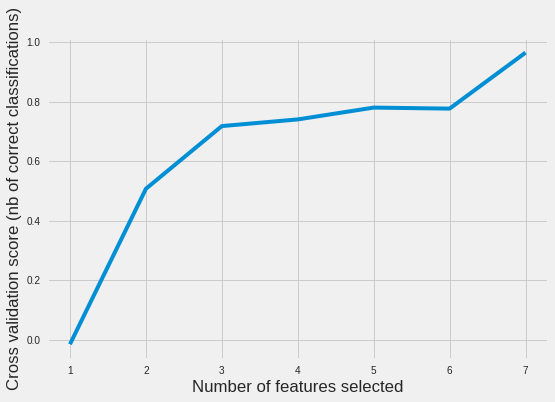

In [22]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

We see that while there is relatively good performance at n = 3, the performance jump at n = 7 is too high to ignore and so that is the number of features which gets selected.

# Data Scaling

An important consideration to make is that the input features are not necessarily on the same scale as they have a variety of natures. To make sure that all variables are fairly evaluated, we standardize the features by subtracting the mean and dividing by the variance so that every feature has mean 0 and variance 1. This process is expedited via sklearn using the StandardScaler

In [0]:
#Initialize scaler
scaler = preprocessing.StandardScaler()

colnames = df.columns

#Standardize
df = scaler.fit_transform(df)

#Stick it back into a dataframe
df = pd.DataFrame(df, columns = colnames)

# Linear Regression Model

When training our linear model, we split the data into two sets, trianing and validation. For our project, we used an 80-20 split between training and validation. Since these splits are made randomly, we repeat the trianing and validation process 1000 times to make sure our evaluation results are not the result of random fluctuations.

When creating the linear model, we designed it so that it would normalize the inputs. sklearn does this by substracting the mean and dividing by the l2 norm. The value in this is that the variables are all put on the same scale avoiding situations where one variable massively outweights the others and also allowing us to look at the relative values of the coefficients of the variables and get meaningfull conclusions.

We evaluate our model on the R^2 scoring system while also tracking the Mean Squared Error. The R^2 score affectively evaluates how close we got to the actual values with our predicted values. We also store the best set of predictions based on R^2 for display later.

In [24]:
#Arrays to store the R^2 and mse values
score = []
mse = []

#The best set of predictions and the relative score
best_pred = []
best_score = 0


for x in range(1000):
  #Split data randomly into training and validation
  train, test = train_test_split(df, test_size = 0.2)

  #Seperate inputs and outputs
  train_y = train['cereal production']
  train_x = train.drop( 'cereal production', axis = 1)
  
  test_y = train['cereal production']
  test_x = train.drop( 'cereal production', axis = 1)
  
  #Initialize the model with normalization on
  regr = sklr(normalize = True)
  
  #Train the model
  regr.fit(train_x, train_y)
  
  #Make the predictions for the validation set
  pred = regr.predict(test_x)
  
  #Update best model if necessary
  if(regr.score(test_x,test_y) > best_score):
    best_pred = pred
    best_real = test_y
  
  #Track diagnostic statistics
  score.append(regr.score(test_x,test_y))
  mse.append(metrics.mean_squared_error(test_y, pred))
  
  
print("R-Squared:    {0} \n"
      "Mean-Squared: {1}".format(np.mean(score),np.mean(mse)))

R-Squared:    0.9691044231086559 
Mean-Squared: 0.03062161619529499


As we can see, our model performed very well with an R-squared of 0.969 which is close to the optimal value of 1. 

## Real Vs. Predicted

We can visualize how close our model was by plotting the predicted values against the real values. The dashed line in the plot below represents the ideal line where we predict exactly the real value for every output.

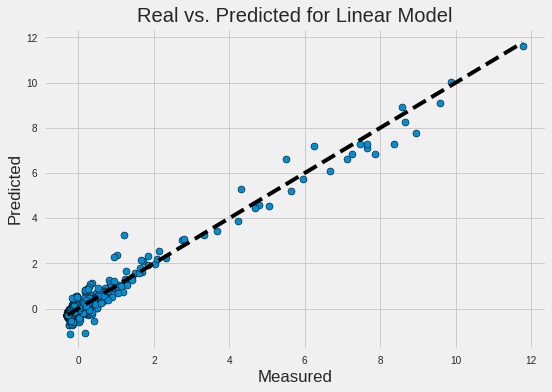

In [25]:
fig, ax = plt.subplots()
ax.scatter(best_real, best_pred, edgecolors=(0, 0, 0))
ax.plot([best_real.min(), best_real.max()], [best_real.min(), best_real.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Real vs. Predicted for Linear Model')
plt.show()

As we can see, our model follows the ideal trend line very closely. The minor fluctuations on either side of the line are both expected and perhaps even necessary. If there were no such fluctuations and our model followed the optimal line exactly we might have concerns over overfitting.

## Coefficient Analysis

One way to interpret our model is to look at the coefficients assigned to each feature. We can't exactly look at the signs of the variables for significance since the interactions between the variables may result in odd sign values for coefficients. However, we can look at the magnitude of the coefficients to see the weight the model assigns to each feature. In a sense, this is then the predictive power of each feature.

In [26]:
pd.Series(regr.coef_, index = list(train_x.columns.values))

tractors                       -0.998487
fertilizer                      1.499986
average precipitation           0.076523
land under cereal production    1.600221
ag total land                  -0.708879
arable land                    -0.238799
land area                      -0.036821
dtype: float64

From the coefficients, it would appear that total land used for producing cereals, fertilizer usage, tractor usage, and total agricultural land are very strong predictors of cereal production.

## Regression With Feature Selection

As an excercise, we retry our regression model using the output from SelectKBest feature selection. From the RFE output, we can see that n = 3 or 4 performs decently well so we use exactly those outputs to train a regression model and compare its metrics to our previous baseline model.

In [27]:
#Aggregate diagnostics
score = []
mse = []

#Store best predictions for display
best_pred = []
best_score = 0

#Use only the selected attributes
selected = selected.tolist()
selected.append('cereal production')
df_selected = df[selected] 

df_selected = df_selected.dropna(axis = 0, how = 'any')

#Iterate 1000 times to avoid random errors
for x in range(1000):
  #Split into trianing validation
  train, test = train_test_split(df_selected, test_size = 0.2)

  #Extract inputs/outputs
  train_y = train['cereal production']
  train_x = train.drop( 'cereal production', axis = 1)
  
  test_y = train['cereal production']
  test_x = train.drop( 'cereal production', axis = 1)
  
  #Intialize model using normalization
  regr = sklr(normalize = True)
  
  #Train model
  regr.fit(train_x, train_y)
  
  #Make the predictions
  pred = regr.predict(test_x)
  score.append(regr.score(test_x,test_y))
  
  #Update best predictions if necessary
  if(regr.score(test_x,test_y) > best_score):
    best_pred = pred
    best_real = test_y
  
  #Aggregate diagnostics
  score.append(regr.score(test_x,test_y))
  mse.append(metrics.mean_squared_error(test_y, pred))
  
  
print("R-Squared:    {0} \n"
      "Mean-Squared: {1}".format(np.mean(score),np.mean(mse)))

R-Squared:    0.8378168703941495 
Mean-Squared: 0.16301899301102554


As we can see, we achieve an R-Squared of 0.83689 which, while still good, is comparitively worse performance wise than our base line model.

## Support Vector Regression(SVR)

Another model we considered is Support Vector Regression which is an adaptation of Support Vector Machines which are used for classification. The model picture looks the same as the Support Vector Machine but rather than learning a classification hyperplane, a regression model is learned which is evaluated for the margin of tolerance for error.

In [28]:
score = []
mse = []

#Store best predictions for display
best_pred = []
best_score = 0

#Iterate 1000 times to avoid random fluctuations
for x in range(1000):
  #Split into train/validation
  train, test = train_test_split(df, test_size = 0.2)

  #Extract features and outputs
  train_y = train['cereal production']
  train_x = train.drop( 'cereal production', axis = 1)
  
  test_y = train['cereal production']
  test_x = train.drop( 'cereal production', axis = 1)
  
  #Initialize and Train the model
  regr = SVR(C = 10, epsilon = 0.2, degree = 6)
  
  regr.fit(train_x, train_y)
  
  #Make the predictions
  pred = regr.predict(test_x)
  
  #Update best predictions if necessary
  if(regr.score(test_x,test_y) > best_score):
    best_pred = pred
    best_real = test_y
  
  #Aggregate the diagnostic data
  score.append(regr.score(test_x,test_y))
  mse.append(metrics.mean_squared_error(test_y, pred))
  
  
print("R-Squared:    {0} \n"
      "Mean-Squared: {1}".format(np.mean(score),np.mean(mse)))

R-Squared:    0.9890446666410526 
Mean-Squared: 0.01086340594367685


We can see that the SVR model performs better than our linear regression model with an R^2 of 0.9889 compared to an R^2 of 0.969. We can visualize the accuracy of the predictions in the same manner as before.

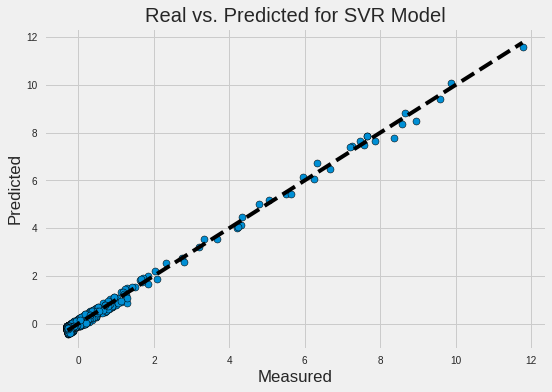

In [29]:
fig, ax = plt.subplots()
ax.scatter(best_real, best_pred, edgecolors=(0, 0, 0))
ax.plot([best_real.min(), best_real.max()], [best_real.min(), best_real.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Real vs. Predicted for SVR Model')
plt.show()

Unfortunately, SVR models do not have a clear interpretation of their meaning as they use a non-linear kernel so the coefficients are not readily available. We can see however than an SVR model is well-suited to predicting cereal production in our system.

## Random Forest Regressor Model

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. We will be using this model to predict the cereal production.

In [0]:
def normalize(df):
    maxim = df.max()
    minim = df.min()
    df = (df - minim)/float(maxim-minim)
    return df

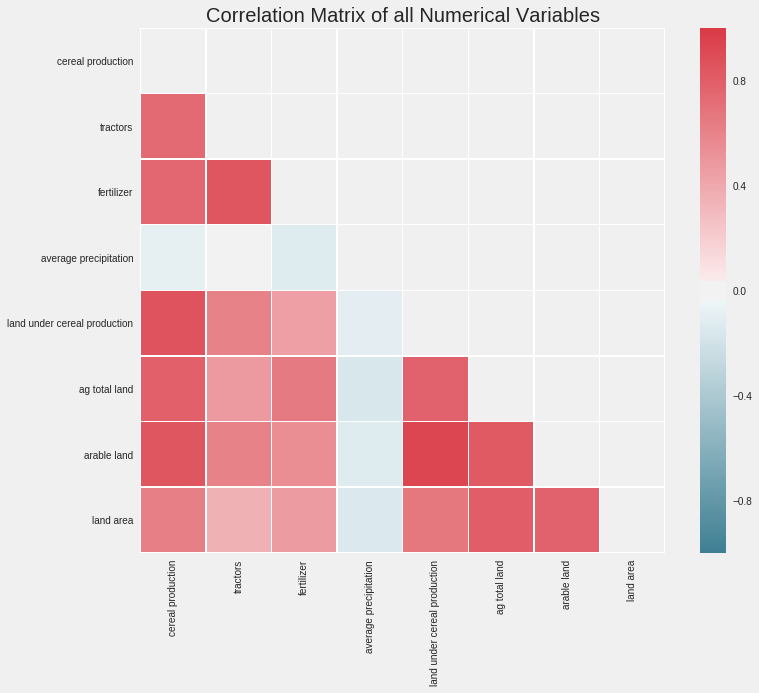

In [31]:
d= df
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, 
            square=True, linewidths=.5, annot=False, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of all Numerical Variables')
plt.show()

In [0]:
score = []
mse = []

#Store best predictions for display
best_pred = []
best_score = 0

#Iterate 1000 times to avoid random fluctuations
for x in range(1000):
  #Split into train/validation
  train, test = train_test_split(df, test_size = 0.2)

  #Extract features and outputs
  train_y = train['cereal production']
  train_x = train.drop( 'cereal production', axis = 1)
  
  test_y = train['cereal production']
  test_x = train.drop( 'cereal production', axis = 1)
  
  #Initialize and Train the model
  regr = RandomForestRegressor(random_state=1)
  
  regr.fit(train_x, train_y)
  
  #Make the predictions
  pred = regr.predict(test_x)
  
  #Update best predictions if necessary
  if(regr.score(test_x,test_y) > best_score):
    best_pred = pred
    best_real = test_y
  
  #Aggregate the diagnostic data
  score.append(regr.score(test_x,test_y))
  mse.append(metrics.mean_squared_error(test_y, pred))

In [33]:
print("R-Squared:    {0} \n"
      "Mean-Squared: {1}".format(np.mean(score),np.mean(mse)))

R-Squared:    0.9902514632510674 
Mean-Squared: 0.009647583222747365


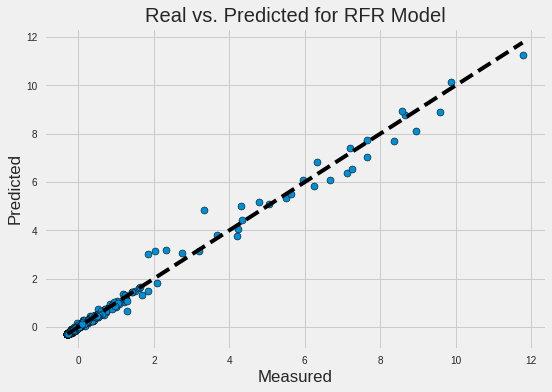

In [34]:
fig, ax = plt.subplots()
ax.scatter(best_real, best_pred, edgecolors=(0, 0, 0))
ax.plot([best_real.min(), best_real.max()], [best_real.min(), best_real.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Real vs. Predicted for RFR Model')
plt.show()

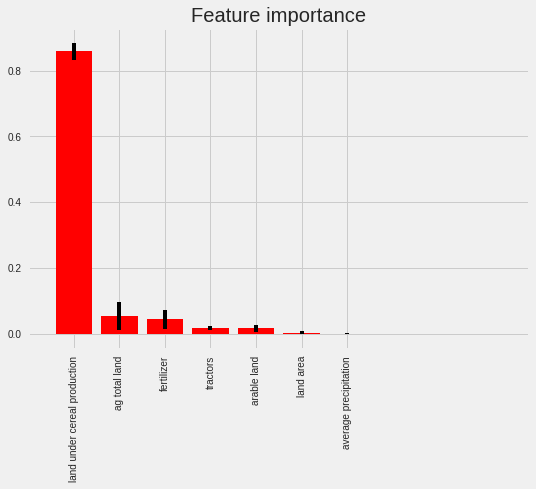

In [35]:
importances = regr.feature_importances_

std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(train_x.shape[1]), importances[indices],  
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_x.shape[1]),train_x.columns[indices], rotation=90)
plt.xlim([-1, 10])
plt.show()

# Conclusions

It appears that our models agree on what the most important features are. The regression model and the random forest regressor both agreed that land used for cereal production, fertilizers, and tractor usage were the major indicators for predicting total cereal production.

We also found through feature selection that the seven features we selected intuitively were all important for our model. We also found that trimming down to four variables also produced decent models, but not models that performed nearly as well as using all 7 variables.

All three of the models performed very well proving to be suitable predictors. Random forest regression performed the best of all three models although only mildly better than Support Vector Regression. Potential work to improve this model includes improved imputation methods or considering a wider or different subset of features.